In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib
from sobol_lib import *
from mpl_toolkits.mplot3d import Axes3D
from gen_mat import *
from block_rect_maxvol import *
import re
import os
from matplotlib import cm
from mva_test import *
import itertools
from ipywidgets import interactive, interact, widgets
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from maxvolpy.maxvol import rect_maxvol, maxvol
from numba import jit
os.environ['OMP_NUM_THREADS'] = '6'
print (os.environ['OMP_NUM_THREADS'])

6


In [3]:
num_expr = 1 # Adding this num to output fn for distinguish between experiments  (not used for now)
nder = 2 # Dimension
ToLoadSet = False # whether to load settigns form file

cut_radiuses = [0.005]
inital_points_distribs = ['LHS']

if ToLoadSet:
    from sandbox_bm_approx_settings import *
else:
    dir_str = './cr_talk'
    #dir_str = os.path.join(os.environ['HOME'], 'work/res/bm-big/')
    num_points_for_big_matrix = 6000 # number of points for big matrix
    max_row =  18                   # Maximum number of points taken in experiments
    max_expansion = 7         # number of columns in big matrix in (nder+1) units
    min_expansion = 3        # minimal number of columns in experiments in (nder+1) units
    

    n_test = 30000    # points on test grid (for calculating error on final step)
    poly = cheb       # used polinomials

    domain_type = None    #possible types: 'blob', 'ellipse', 'plane', 'rhombus', 'circle'
    
    
#####
dir_pdf = os.path.join(dir_str, "pdf")
try:
    os.makedirs(dir_pdf)
except:
    pass



ToTakePointsFromFile = False # (not used for now)

# ---------------------------------
p_size = (nder+1)*max_row #number of rows in big matrix

### generating test points
points_test = complex_area_pnts_gen(n_test, nder, distrib='LHS', mod = domain_type)

### Testing the new most general environment

In [ ]:
### evaluating test
for inital_points_distrib in inital_points_distribs:
    points_fn = 'taken_points_{}'.format(inital_points_distrib)
    x = complex_area_pnts_gen(num_points_for_big_matrix, nder, distrib='lhs', mod = domain_type)

    A = GenMat(p_size, x, poly=poly, debug=False, pow_p=1)
    A = matrix_prep(A, nder+1)
    
    np.savez(os.path.join(dir_str, points_fn), x=x, points_test=points_test)
    
    
    
    fn_pre_pdf = "distrib={}".format(inital_points_distrib)
    for cut_radius in cut_radiuses:
        f = open(os.path.join(dir_str, "distrib={}_radius={}".format(inital_points_distrib, cut_radius) + '.txt'), "w")
        for expansion in range(min_expansion, max_expansion):
                    for N_rows_ex in range(max_row, expansion, -1): # It's not the way people do...
                        N_rows = N_rows_ex*(nder+1)
                        fnpdf = os.path.join(dir_pdf, fn_pre_pdf + "_expansion={}_N_rows_ex={}.pdf".format(expansion, N_rows_ex))
                        try:
                            taken_points = test_bm(A, x,nder, expansion, N_rows, cut_radius = cut_radius,to_save_pivs=N_rows_ex==max_row, 
                                                       fnpdf=fnpdf)
                        except SingularError as err:
                            print ('not full column rank with expansion={}, N_rows_ex={}, err={}'.format(
                                                                expansion, N_rows_ex, err.value)) 
                            #continue
                            break
                            


                        taken_points.tofile(f, sep=" ")
                        f.write("_Nrows={}_expans={}\n".format(N_rows, expansion))
                        f.flush()

        f.close()


### Experimental data processing

In [2]:
### Data extraction
dir_str = './'
dir_points = os.path.join(dir_str, "cr_test_7-20-Square_fine/")
domain_type= None
nder = 2
points_distrib = 'LHS'
#rad = "0.015"
taken_points = np.load(dir_points + "taken_points_" + points_distrib + ".npz")
#taken_points = np.load(dir_points + "taken_points_" + points_distrib + "_rad=" + rad + ".npz")
x = taken_points['x']
points_test = taken_points['points_test']
#fn = dir_points + "distrib=" + points_distrib + "_radius=" + rad + ".txt"

In [ ]:
### .txt processing
N_row, N_col, p_indices = file_extraction(dir_points + "distrib=" + points_distrib + "_radius=" + rad + ".txt")

In [3]:
def index_preproc(N_row,N_col,exp_mask,step_along=1,new_extr_path = None):
    if new_extr_path:
        N_row, N_col, p_indices = file_extraction(new_extr_path)
    ndim = 3
    ent=[N_col, N_row]
    indx = np.array(())
    for axis, indxs_to_extract in enumerate(exp_mask[:-1]):
        indx = np.concatenate((np.where(np.in1d(ent[axis], indxs_to_extract))[0][::step_along], indx))
    if exp_mask[-1]:
        indx = np.concatenate((np.where(N_row//ndim == np.around(exp_mask[-1]*N_col))[0][::step_along],indx))
    indx = np.unique(indx)
    return(indx.astype(int))

In [4]:
@jit
def mult_error_tensor(N_iter, N_row, N_col,function, error_set, shape=None):
    nder = 2
    ndim = nder + 1
    error_tensor = np.empty((len(error_set), N_col.shape[0], N_iter))
    if type(function) is not list:
            function = [function]
    ValsandNorms = MakeValsAndNorms(function, points_test)
    for i in np.arange(N_iter):
        print('Iteration #{}'.format(i))
        for j, p in enumerate(N_col):
            for k, points_type in enumerate(error_set):
                x_tmp = complex_area_pnts_gen(N_row[j]//ndim, nder, mod=shape, distrib=points_type)
                if points_type=='sobol' and len((np.where(x_tmp == np.array([[0.,0.],])))[0])!=0:

                    while True:
                        x_tmp = complex_area_pnts_gen(N_row[j]//ndim, nder, mod=domain_type, distrib='sobol')
                        if len((np.where(x_tmp == np.array([[0.,0.],])))[0])==0:
                            break
                _, error_tensor[k][j,i] = LebesgueConst(x_tmp, N_col[j]*ndim, poly=cheb, test_pnts=points_test, pow_p=1, funcs=ValsandNorms, derivative = True)

                    
        #if (i%5 == 0):
            #tensor_name = 'error_tensor_{}_{}'.format(domain_type, function[0].__name__)
            #np.savez(os.path.join(dir_points, tensor_name), error_tensor=error_tensor)
    return(error_tensor)

In [5]:
@jit
def bmaxvol_error(function,points_test,p_indices, ix):
    error_bmaxvol, Leb_e = [], []
    nder = 2

    if type(function) is not list:
            function = [function]

    ValsandNorms = MakeValsAndNorms(function, points_test)
    for j, p in enumerate(p_indices[ix]):
        _,b = LebesgueConst(x[p], N_col[ix][j]*(nder+1), poly=cheb, test_pnts=points_test, pow_p=1, funcs=ValsandNorms, derivative = True)
        error_bmaxvol.append(b)
    bmv = np.array(error_bmaxvol).reshape((1,len(error_bmaxvol)))
    return(bmv)

In [6]:
def error_tensor_plot(fn, mean_tensor, T_up, T_down,error_set, inx,ix_g,experiment_params, confidence = False):
    ndim = 3
    N_row, N_col,_ = file_extraction(fn)
    ax = experiment_params[0]
    if experiment_params[0] == 2:
        ax = 0
    N_row //= ndim
    N_col *= ndim
    ent_list = [N_row[ix_g], N_col[ix_g]]
        
    fig = plt.figure()
    plt.yscale('log')
    for k, points_type in enumerate(error_set):
        plt.plot(ent_list[ax][inx], mean_tensor[k][inx], label = points_type)
        if confidence and points_type != 'BMaxvol' and points_type!= 'Maxvol':
            plt.fill_between(ent_list[ax][inx], T_down[k][inx], T_up[k][inx],alpha = 0.4,label = '95% CI_'+points_type)
    
    if experiment_params[0]==1:
        plt.xlabel('Number of basis functions', fontsize=10)
        fnpdf = dir_points+'err(cols)_points={}_func={}.pdf'.format(experiment_params[1],experiment_params[2])
    elif experiment_params[0] == 0:
        plt.xlabel('Number of points', fontsize=10)
        fnpdf = dir_points+'err(rows)_monoms={}_func={}.pdf'.format(experiment_params[1],experiment_params[2])
    else:
        plt.xlabel('Number of points', fontsize=10)
        fnpdf = dir_points+'err(points)_coef={}_func={}.pdf'.format(experiment_params[1],experiment_params[2])
    plt.ylabel('Approximation error, $\epsilon$', rotation=90, labelpad=5)
    plt.legend()
    plt.grid(True)
    plt.savefig(fnpdf)
    plt.close(fig)   

In [7]:
### Experiment setup
error_set = ['lhs','sobol','random']
non_random_error_set = ['BMaxvol']


solve_all_mesh = False
N_iter = 10
col_to_fix = []
point_to_fix = [60]
slice_coeff = None

exp_solve = [[],[],[]]
if solve_all_mesh:
    exp_solve = [np.unique(np.arange(N_col[0],N_col[-1])),[],None]
    exp_plot[0] = col_to_fix
    exp_plot[1] = point_to_fix
    exp_plot[2] = slice_coeff
else:
    exp_solve[0] = col_to_fix
    exp_solve[1] = point_to_fix
    exp_solve[2] = slice_coeff
    exp_plot = exp_solve

In [ ]:
#N_row = np.hstack([np.arange(num_points_max,i,-1) for i in range(min_col_exp,max_col_exp)])
#N_col = np.hstack([i*np.ones(np.arange(num_points_max,i,-1).shape[0]) for i in range(min_col_exp,max_col_exp)])

In [ ]:
ix = index_preproc(N_row,N_col,exp_solve,step_along=1, new_extr_path = None)

In [ ]:
## Error calculation
function_set = [f_sincos]
for function in function_set:
    error_tensor = mult_error_tensor(N_iter,N_row[ix], N_col[ix],function, error_set, shape=domain_type)
    tensor_name = 'error_tensor_{}_{}_exp2_1'.format(domain_type, function.__name__)
    np.savez(os.path.join(dir_points, tensor_name), error_tensor=error_tensor)

In [ ]:
function = f_sincos
tensor_name = 'error_tensor_{}_{}_exp2'.format(domain_type, function.__name__)
error_saved_t = np.load(os.path.join(dir_points, tensor_name) + ".npz")
error_tensor = error_saved_t['error_tensor']

tensor_name = 'error_tensor_{}_{}_exp2_1'.format(domain_type, function.__name__)
error_add = np.load(os.path.join(dir_points, tensor_name) + ".npz")
error_tensor_add = error_add['error_tensor']

full_tensor = np.concatenate((error_tensor,error_tensor_add),axis=2)

tensor_name = 'error_tensor_{}_{}_exp2'.format(domain_type, function.__name__)
np.savez(os.path.join(dir_points, tensor_name), error_tensor=full_tensor)

In [ ]:
function = f_sincos

bmxvol_error = bmaxvol_error(function,points_test)

In [ ]:
### Plotting
error_set = ['lhs','sobol','random']
non_random_error_set = ['BMaxvol']
function_set = [f_sincos]
error_set += non_random_error_set
for function in function_set:
    tensor_name = 'error_tensor_{}_{}_exp2'.format(domain_type, function.__name__)
    error_saved = np.load(os.path.join(dir_points, tensor_name) + ".npz")
    error_tensor = error_saved['error_tensor']
    print(error_tensor.shape)
    z = 1.28    #z-value for 95% confidence interval
    k = z / np.sqrt(error_tensor.shape[2])    #correcting by a square root from a number of experiments
    mean_tensor = np.mean(error_tensor,axis = 2)

    T_up = mean_tensor + k*np.std(error_tensor, axis = 2)
    T_down = mean_tensor - k*np.std(error_tensor, axis = 2)
    
    mean_tensor = np.concatenate((mean_tensor,bmxvol_error),axis=0)
    
    for axis, jx in enumerate(exp_plot[:-1]):
        for count, fixed_entity in enumerate(jx):
            local_design = [[],[],[]]
            local_design[axis] = fixed_entity
            ix_internal = index_preproc(N_row[ix],N_col[ix],local_design,step_along=1, new_extr_path = None)
            error_tensor_plot(fn, mean_tensor,T_up,T_down,error_set, ix_internal,ix,[axis, fixed_entity,function.__name__], confidence = True)
    if exp_plot[-1]:
        local_design = [[],[],[]]
        local_design[2] = exp_plot[-1]
        ix_internal = index_preproc(N_row[ix],N_col[ix],local_design,step_along=1, new_extr_path = None)
        error_tensor_plot(fn, mean_tensor,T_up,T_down,error_set, ix_internal,ix,[2,exp_plot[-1],function.__name__], confidence = True)

    

In [ ]:
blob_wave_shape(x[p_indices[20]])

In [ ]:
blob_wave_shape(points_test)

In [ ]:
x_min = 4
x_max = 7
pts_max = 10

In [ ]:
def maxvol_test(x, nder, N_row, N_col, poly):
    ndim = nder + 1
    maxvol_p_indices = np.empty((N_col.shape[0],),dtype=object)
    for i in np.unique(N_col):
        #p_size = np.unique(N_col)[i]#*ndim
        p_size = i 
        A = GenMat(p_size, x, poly=poly, debug=False, pow_p=1)
        A = A[:x.shape[0]]
        loc_idx = np.where(N_col == i)[0]
        loc_max_pts = N_row[loc_idx][np.argmax(N_row[loc_idx])] // ndim
        taken_points_nonblock,_ = rect_maxvol(A, maxK = loc_max_pts, minK = loc_max_pts)
        for j in loc_idx:
            maxvol_p_indices[j] = list(taken_points_nonblock[:N_row[j] // ndim])
        
    return(maxvol_p_indices)
    

In [ ]:
A = GenMat(30, x, poly=cheb, debug=False, pow_p=1)
A = A[:x.shape[0]]

taken_points_nonblock,_ = rect_maxvol(A, maxK = 38, minK = 38)
p1 = taken_points_nonblock[:30]

In [ ]:
maxvol_p_ind = maxvol_test(x,nder,N_row[ix],N_col[ix],cheb)

In [ ]:
ValsandNorms = MakeValsAndNorms(function, points_test)
error_mva = []
for j, p in enumerate(maxvol_p_ind):
    print(N_col[ix][j],x[p].shape)
    _,c = LebesgueConst(x[p], N_col[ix][j]*(nder+1), poly=cheb, test_pnts=points_test, pow_p=1, funcs=ValsandNorms, derivative = True)
    error_mva.append(c)

In [ ]:
error_mva = []
for j in range(3,19):
    _,c = LebesgueConst(x[p1], j*(nder+1), poly=cheb, test_pnts=points_test, pow_p=1, funcs=ValsandNorms, derivative = True)
    error_mva.append(c)

### Random points plot

### Draw areas

In [ ]:
#col_exp = min_expansion
col_exp = 40
i = np.where(N_col == col_exp)[0][0]
taken_indices = p_indices[i]
N_points = len(p_indices[i])

In [ ]:
parameter_plot(len(p_indices[i]))

In [ ]:
x = complex_area_pnts_gen(1400, nder, mod='plane', distrib='Sobol')

In [ ]:
def LebesgueConst_w(pnts, l,uwu, poly=cheb,test_pnts=None, pow_p=1, funcs=None):
    A = GenMat(l, pnts, poly=poly, debug=False, pow_p=pow_p, ToGenDiff=True)
    nder = pnts.shape[1]
    A = matrix_prep(A, nder+1)
    ewe = np.array([[1],[1],[1]])
    weeght = np.kron(uwu,ewe)
    C = weeght*A
    ABig = GenMat(l, test_pnts, poly=poly, debug=False, pow_p=pow_p, ToGenDiff=False)
    F = np.linalg.pinv(A).T.dot(ABig.T)
    for f, fvals, fnorm in funcs:
        rhs = RHS(f, pnts, derivative = True)
        print rhs.shape
        print weeght.shape
        rhs1 = weeght.T*rhs
        rhs1 = rhs1.reshape(rhs1.shape[1])
        #rhs = rhs1.reshape(42)
        res = np.linalg.norm(F.T.dot(rhs) - fvals, np.inf)/fnorm

    return res


In [ ]:
A = GenMat(6, x, poly=power, debug=False, pow_p=1)

In [ ]:
taken_points = np.load("piston_10_error.npz")

In [ ]:
x = taken_points['er']

In [ ]:
data = np.load("piston_10.npz")

In [ ]:
er_lhs = data['er_lhs']
er_r = data['er_r']
er_s = data['er_s']

### Radial functions

In [ ]:
def ellipse_sp(x,y):
    b,e = 0.2,0.95
    sigma,n = 1/2, 1
    r = sp.sqrt(x**2 + y**2)
    phi = sp.atan2(y,x)
    R = r*sp.sqrt(1 - (e*sp.cos(phi))**2)/b
    return((sp.exp(-1*(R**2)/(2*(sigma**2))))*sp.cos(n*phi))

def sin_blob_sp(x,y):
    a = 0.2
    b = 0.8
    sigma,n = 1,7
    r = sp.sqrt(x**2 + y**2)
    phi = sp.atan2(y,x)
    R = r*(1/(b + a*sp.cos(n*phi)))
    return((sp.exp(-1*(R**2)/(2*(sigma**2))))*(r**2))

f_ellipse = symb_to_func(ellipse_sp,    2, True, False, name='Ellipse')  
f_sin_blob= symb_to_func(sin_blob_sp,   2, True, False, name='Blob')  

f_ellipse.diff    = MakeDiffs(ellipse_sp,  2)
f_sin_blob.diff   = MakeDiffs(sin_blob_sp, 2)

In [ ]:
fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')

# Make data.
a = 1.1
X = np.linspace(-a, a, 1000)
Y = np.linspace(-a, a, 1000)
phi = np.arange(0,2*np.pi, 0.01)
b= 0.2
e = 0.95
X, Y = np.meshgrid(X, Y)

#r = (b / np.sqrt(1-(e*np.cos(phi))**2))
#xx = r*np.cos(phi)
#yy = r*np.sin(phi)

r = 0.8 + 0.2*np.cos(7*phi)
xx = r*np.cos(phi)
yy = r*np.sin(phi)

#Z = f_ellipse(X,Y)
#Z = f_sin_blob(X,Y)
Z = f_gauss_doubl(X,Y) - 2

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.summer,
                       linewidth=0,label = 'Trigonometric')
#fc = ax.plot(xx, yy,'bo', zs=0, zdir='z', label='curve in (x,y)')
# Customize the z axis.
ax.set_zlim(-1, 1)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.4, aspect=5)
plt.grid(True)
#fnpdf = 'ellips.pdf'
#plt.savefig(fnpdf)
plt.show()

In [30]:
radiuses = ['0.0','0.01','0.015','0.02','0.025','0.03','0.04','0.05','0.06','0.07','0.08','0.09','0.1','0.11','0.12','0.13','0.15','0.18','0.2','0.25']#,'0.4']
funcs = [f_gauss,f_rosenbrock,f_sincos,f_schafferf6,f_roots,f_yaf1,f_gabor]

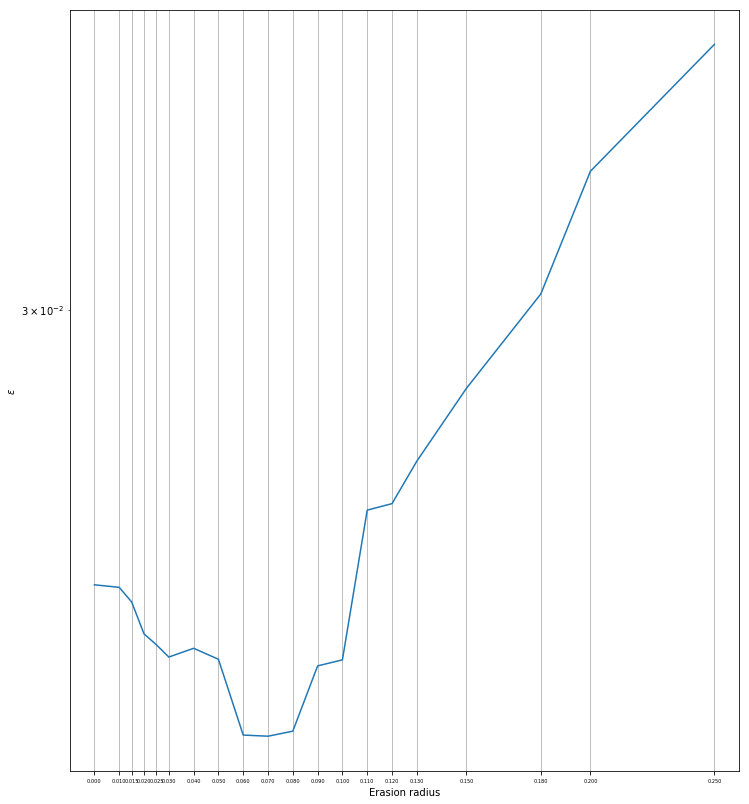

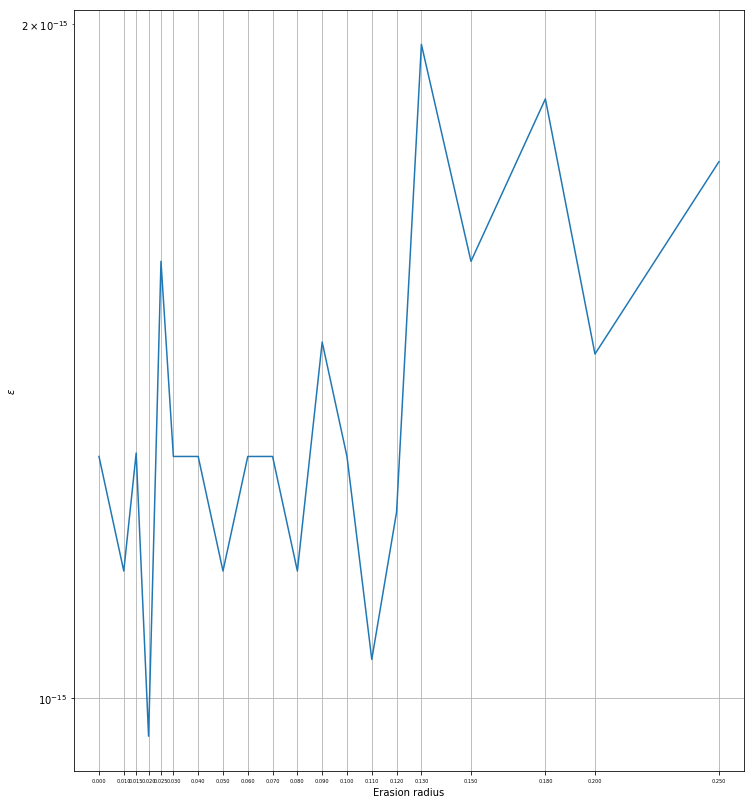

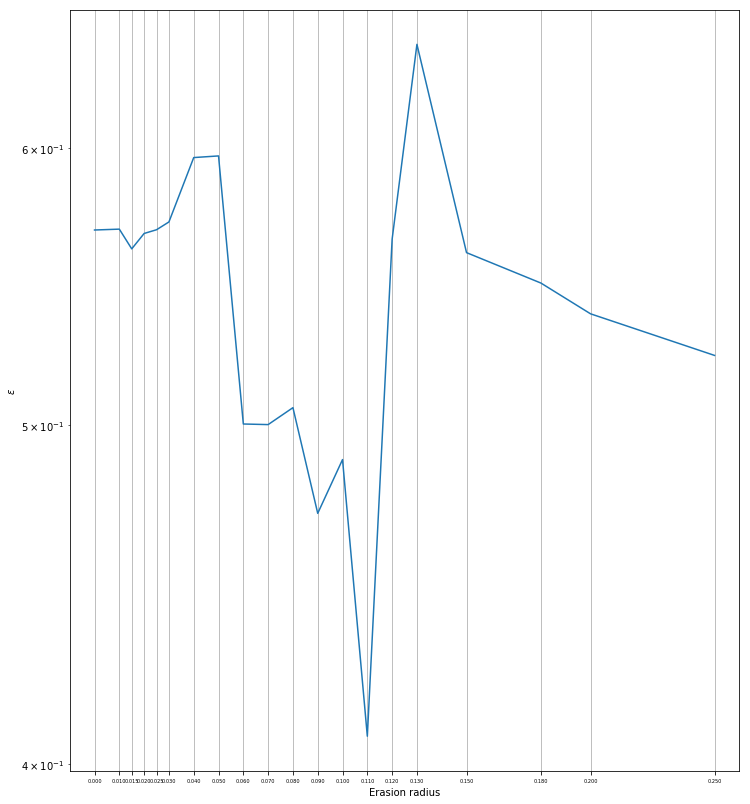

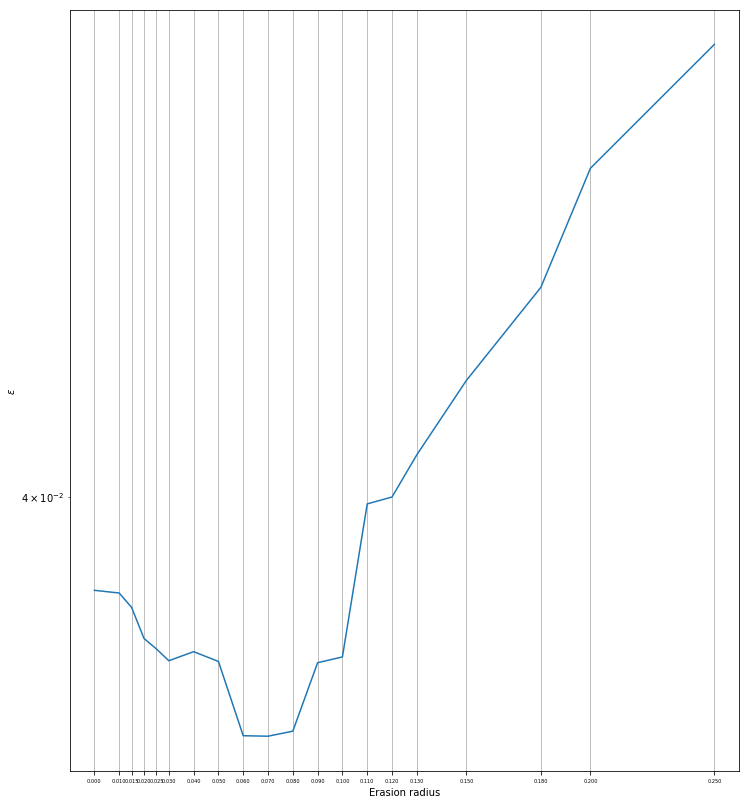

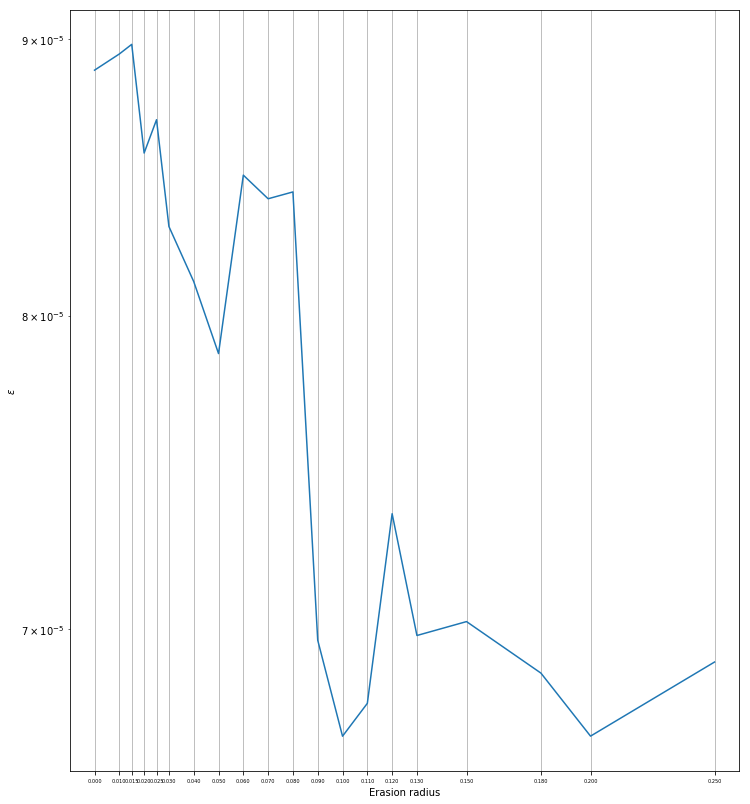

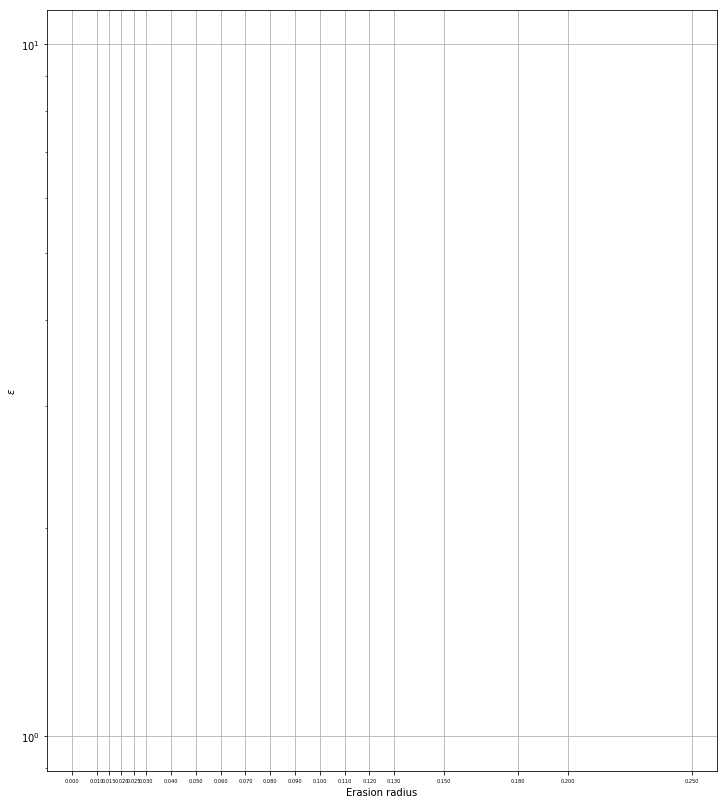

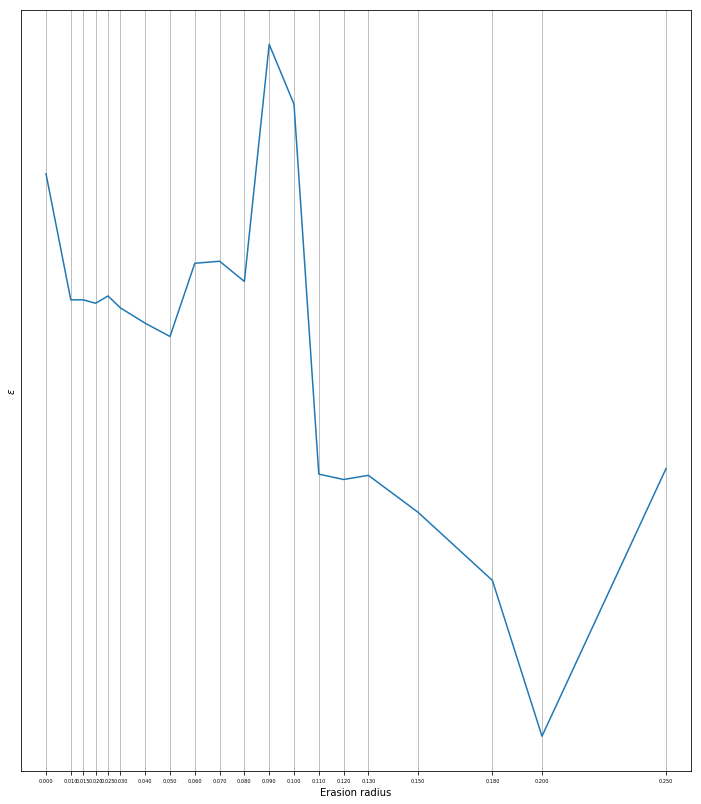

In [31]:
for function in funcs:
    error_rad = []
    #volume = []
    for rad in radiuses:
        fn = dir_points + "distrib=" + points_distrib + "_radius=" + rad + ".txt"
        N_row, N_col, p_indices = file_extraction(dir_points + "distrib=" + points_distrib + "_radius=" + rad + ".txt")
        ix = index_preproc(N_row,N_col,exp_solve,step_along=1, new_extr_path = None)

        #pts = p_indices[ix][0]

        #A = GenMat(N_col[ix][0]*(nder+1), x[pts], poly=cheb, debug=False, pow_p=1)
        #A = matrix_prep(A, nder+1)
        #vol = la.det(A.T @ A)
        #volume.append(vol)
        bmxvol_error = bmaxvol_error(function,points_test,p_indices,ix)
        error_rad.append(bmxvol_error)
    fig, ax = plt.subplots(1, 1, figsize=(12, 14))

    ax.set_xlim(-0.01, 0.26)
    plt.yscale('log')
    plt.xticks(np.array(radiuses,dtype=float), fontsize=5)
    plt.plot(np.array(radiuses,dtype=float),np.array(error_rad)[:,0,0])
    plt.xlabel('Erasion radius', fontsize=10)
    plt.ylabel('$\epsilon$')
    plt.grid(True)
    fnpdf = 'error-rad_fine_func={}.pdf'.format(function.__name__)
    plt.savefig(fnpdf)

### Weighted maxvol

In [2]:
nder = 2
domain_type = None
p_size = 9
x = complex_area_pnts_gen(10000, nder, distrib='lhs', mod = domain_type)
A = GenMat(p_size, x, poly=cheb, debug=False, pow_p=1)
A = matrix_prep(A, nder+1)
#piv = rect_block_maxvol(A, nder, 18, max_iters=200, rect_tol = 0.05, tol = 0.0,debug = False, to_erase = None)
perm, C = block_maxvol(A, nder, tol = 0.05, max_iters=200, swm_upd=True)
A = A[perm]

In [24]:
def rect_block_backward_core(C, P, nder, Kmax, t = 0.05, to_erase=None):
    ndim = nder + 1
    n, m = C.shape
    num_block = n // ndim
    k = int(Kmax // ndim)
    Fl = True
    block_index = m // ndim
    non_unique_block_piv = np.copy(P[:m:ndim]//ndim)
    block_indcs = P[::ndim]//ndim
    S = cold_start_tens(C,ndim)

    while Fl and block_index < k:
        det_list = la.det(np.eye(ndim) + S)
        elem = np.argmax(det_list)
        
        if det_list[elem] > (1 + t):
            range_new_block = np.arange(elem*ndim, elem*ndim + ndim)

            
            #------ update part -----            
            block = np.eye(ndim) + C[range_new_block].dot(C[range_new_block].T)
            op3 = C.dot(la.solve(block,C[range_new_block]).T)
            op4 = np.dot(op3, C[range_new_block])
                   
            
            C = np.hstack((C - op4, op3))
            S = cold_start_tens(C,ndim)
        
            if not np.isin(block_indcs[elem],non_unique_block_piv):
                block_index += 1
            
            non_unique_block_piv = np.hstack((non_unique_block_piv,block_indcs[elem]))
        else:
            print('No relevant elements found')
            Fl = False
    print(block_index)
    return(non_unique_block_piv, np.unique(non_unique_block_piv))


def rect_backward_naive(A,nder,Kmax,t=0.05):
    ndim = nder + 1
    n, m = A.shape
    k = int(Kmax // ndim)
    ids = np.copy(A[:m])
    C = np.dot(A,np.linalg.pinv(ids))
    
    block_index = m // ndim
    
    block_indcs = np.arange(int(n//ndim))
    non_unique_block_piv = np.copy(block_indcs[:(int(m//ndim))])
    S = cold_start_tens(C,ndim)
    
    Fl = True
    
    test_iter = 0
    
    while Fl and block_index < k and test_iter < 9:
        det_list = la.det(np.eye(ndim) + S)
        elem = np.argmax(det_list)
        print(det_list[elem], elem)
        print(det_list[non_unique_block_piv])
        print('C shape before extension', C.shape)
        if det_list[elem] > (1 + t):
            range_new_block = np.arange(elem*ndim, elem*ndim + ndim)
            ids = np.vstack((ids,A[range_new_block]))
            
            if not np.isin(block_indcs[elem],non_unique_block_piv):
                block_index += 1
            
            non_unique_block_piv = np.hstack((non_unique_block_piv,block_indcs[elem]))
            
            C = np.dot(A,np.linalg.pinv(ids))
            S = cold_start_tens(C,ndim)
            
            print('C shape after extension', C.shape)
            print('submatrix shape', ids.shape)
            print('-----------------------')
            test_iter += 1
        else:
            print('no elements found')
            Fl = False
    
    
    return(non_unique_block_piv, np.unique(non_unique_block_piv))

In [71]:
tt,ttt = rect_block_backward_core(C, perm, nder, Kmax=30, t = 0.06, to_erase=None)

No relevant elements found
6


In [25]:
yy,yyy = rect_backward_naive(A,nder,Kmax = 18,t=0.05)

409.0700520599267 2577
[8. 8. 8.]
C shape before extension (30000, 9)
C shape after extension (30000, 12)
submatrix shape (12, 9)
-----------------------
51.83013894807753 629
[4.02156831 6.68825618 5.77999941 4.62721225]
C shape before extension (30000, 12)
C shape after extension (30000, 15)
submatrix shape (15, 9)
-----------------------
4.8382811960792536 2
[2.41829574 4.75871026 4.8382812  4.20263578 4.08801748]
C shape before extension (30000, 15)
C shape after extension (30000, 18)
submatrix shape (18, 9)
-----------------------
4.627281411548704 1
[2.30880785 4.62728141 2.74314567 3.76075075 4.02101295 2.74314567]
C shape before extension (30000, 18)
C shape after extension (30000, 21)
submatrix shape (21, 9)
-----------------------
3.6720296520197837 2577
[2.18206306 2.68836858 2.71037686 3.67202965 3.58150738 2.71037686
 2.68836858]
C shape before extension (30000, 21)
C shape after extension (30000, 24)
submatrix shape (24, 9)
-----------------------
3.5113080748447087 629
[